In [1]:
import pickle
import os
import numpy as np

In [2]:
from quchem_ibm.exp_analysis import *

def dict_of_M_to_list(M_dict, PauliOP):
    
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    list_of_M_bitstrings=None
    for bit_string, N_obtained in M_dict.items():
        
        M_string = np.take(list(bit_string[::-1]), P_Qubit_list) # only take terms measured! Note bitstring reversed!
        
        array_meas = np.repeat(''.join(M_string), N_obtained)
        if list_of_M_bitstrings is None:
            list_of_M_bitstrings=array_meas
        else:
            list_of_M_bitstrings=np.hstack((list_of_M_bitstrings,array_meas))
    
    # randomly shuffle (seed means outcome will always be the SAME!)
#     np.random.seed(42) 
    np.random.shuffle(list_of_M_bitstrings) 
    
    return list_of_M_bitstrings

In [3]:
# # input for exp
base_dir = os.getcwd()
input_file = os.path.join(base_dir, 'LiH_simulation_RESULTS_time=2020Oct07-163210198971.pickle')
with open(input_file, 'rb') as handle:
    LiH_data = pickle.load(handle)


In [4]:
experimental_data_LCU = LiH_data['experiment_data'].copy()

del LiH_data

In [5]:
LCU_data = experimental_data_LCU[101852100]['LCU'].copy()
del experimental_data_LCU


In [6]:
LCU_Hist_data_sim={}

for exp_instance in LCU_data: #each exp repeated 10 times!
    for exp_dict_key in exp_instance:

        exp_dict= exp_instance[exp_dict_key]

        if 'Pn' in exp_dict.keys():
            P=exp_dict['Pn']
            coeff = exp_dict['gamma_l']

            measured_dict_sim = exp_dict['measurement_dict'] # post selection already done!

        else:
            P=exp_dict['qubitOp']
            coeff = exp_dict['coeff']
            measured_dict_sim = exp_dict['measurement_dict']

        M_list_sim = dict_of_M_to_list(measured_dict_sim, P)

        if exp_dict_key in LCU_Hist_data_sim.keys():
            LCU_Hist_data_sim[exp_dict_key]={'P':P ,'coeff': coeff, 'Measurements': np.hstack((LCU_Hist_data_sim[exp_dict_key]['Measurements'],M_list_sim))}
        else:
            LCU_Hist_data_sim[exp_dict_key]={'P':P ,'coeff': coeff, 'Measurements': M_list_sim}

                
# as probablistic need to all be same shape (cannot have more measurements of one term)
fewest_succ_shots_sim = min([LCU_Hist_data_sim[key]['Measurements'].shape[0] for key in LCU_Hist_data_sim])
# for exp_dict_key in exp_instance:
#     exp_dict= exp_instance[exp_dict_key]
#     if 'Pn' in exp_dict.keys():
#         LCU_Hist_data_sim[exp_dict_key]['Measurements']= LCU_Hist_data_sim[exp_dict_key]['Measurements'][:fewest_succ_shots_sim]
for key in LCU_Hist_data_sim.keys():
    LCU_Hist_data_sim[key]['Measurements']= LCU_Hist_data_sim[key]['Measurements'][:fewest_succ_shots_sim]
    

In [7]:
LCU_Hist_data_sim[0]['Measurements'].shape

(1447349,)

In [8]:
# ### save output
# np.save('LCU_hist_data', STANDARD_Hist_data_sim)

In [9]:
import matplotlib.pyplot as plt

In [10]:
fci_energy= -7.971184315565538

# Histogram

In [11]:
from tqdm.notebook import tqdm
def Get_Hist_data(Histogram_data, I_term):
    E_list=[]
    for m_index in tqdm(range(Histogram_data[0]['Measurements'].shape[0])):
        E=I_term
        for M_dict_key in Histogram_data:
            coeff = Histogram_data[M_dict_key]['coeff']
            parity =  1 if sum(map(int, Histogram_data[M_dict_key]['Measurements'][m_index])) % 2 == 0 else -1
            E+=coeff*parity
        E_list.append(E)
    return E_list
    

In [12]:
I_term = -4.142299396835105

E_LCU_list_sim=Get_Hist_data(LCU_Hist_data_sim, I_term)

In [13]:
del LCU_data

In [14]:
E_LCU_list_sim=np.array(E_LCU_list_sim, dtype=float).tolist()

/Users/lex/anaconda3/envs/UpdatedCirq/lib/python3.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [15]:
import json
with open("E_LCU_list_sim.json", "w") as write_file:
    json.dump(E_LCU_list_sim, write_file)

In [16]:
E_LCU_list_sim=np.array(E_LCU_list_sim)

In [20]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean)**2 / (2*standard_deviation**2)))

In [18]:
from scipy.optimize import curve_fit

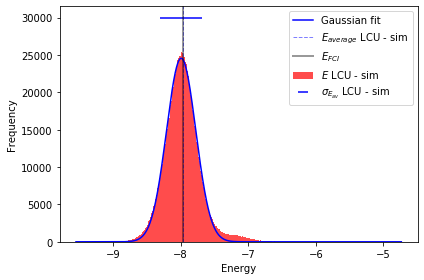

In [19]:
# from matplotlib import pyplot
# %matplotlib inline
# # %matplotlib notebook


# # bins = len(set(E_LCU_list_sim))

# bins = 500


# bin_heights_LCU_sim, bin_borders_LCU_sim, _=pyplot.hist(E_LCU_list_sim, bins, alpha=0.7, 
#                                                                 label='$E$ LCU - sim', 
#                                                                 color='r',
#                                                               density=False)

# bin_centers_LCU_sim = bin_borders_LCU_sim[:-1] + np.diff(bin_borders_LCU_sim) / 2
# popt, _ = curve_fit(gaussian, bin_centers_LCU_sim, bin_heights_LCU_sim, p0=[fci_energy, 0., 1], **{'maxfev':10000})
# mean_LCU_sim, amplitude_LCU_sim, standard_deviation_LCU_sim= popt
# x_interval_for_fit = np.linspace(bin_borders_LCU_sim[0], bin_borders_LCU_sim[-1], 10000)
# pyplot.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='b')

# # pyplot.axvline(mean_LCU_sim, alpha=0.5, color='r', linestyle='dashed', linewidth=1, 
# #             label='$E_{average}$ LCU - sim') # mean of GAUSSIAN FIT
# pyplot.axvline(E_LCU_list_sim.mean(), alpha=0.5, color='b', linestyle='dashed', linewidth=1, 
#             label='$E_{average}$ LCU - sim') # mean of DATA

# pyplot.errorbar(mean_LCU_sim,30_000,
#              xerr=standard_deviation_LCU_sim, linestyle="None", color='b',
#              uplims=True, lolims=True, label='$\sigma_{E_{av}}$ LCU - sim')

# pyplot.axvline(fci_energy, color='k', linestyle='solid', linewidth=2, 
#             label='$E_{FCI}$', alpha=0.4)

# pyplot.legend(loc='upper right')
# # pyplot.legend(bbox_to_anchor=(0.865,1.9), loc="upper left")
# pyplot.ylabel('Frequency')
# pyplot.xlabel('Energy')

# pyplot.tight_layout()

# file_name = 'LiH_Histogram_sim_LCU_Gaussian.jpeg'
# # pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
# pyplot.show()

In [21]:
len(set(np.around(E_LCU_list_sim, 5)))

154764

In [28]:
# https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
from scipy.stats import iqr

bin_width = 2 * iqr(E_LCU_list_sim) / E_LCU_list_sim.shape[0]**(1/3)
np.ceil((max(E_LCU_list_sim)-min(E_LCU_list_sim))/bin_width)

897.0

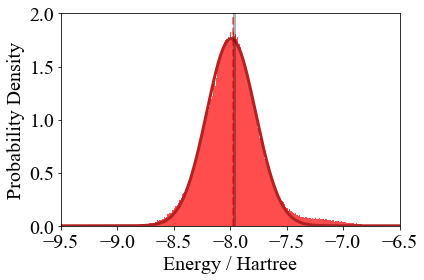

In [31]:
from matplotlib import pyplot
%matplotlib inline
# %matplotlib notebook

# bins = 150_000
bins = 2500


bin_heights_LCU_sim, bin_borders_LCU_sim, _=pyplot.hist(E_LCU_list_sim, bins, alpha=0.7, 
                                                                label='$E$ LCU - sim', 
                                                                color='r',
                                                              density=True)
### Gaussian Fit
bin_centers_LCU_sim = bin_borders_LCU_sim[:-1] + np.diff(bin_borders_LCU_sim) / 2
popt, _ = curve_fit(gaussian, bin_centers_LCU_sim, bin_heights_LCU_sim, p0=[fci_energy, 0., 1], **{'maxfev':10000})
mean_LCU_sim, amplitude_LCU_sim, standard_deviation_LCU_sim= popt
x_interval_for_fit = np.linspace(bin_borders_LCU_sim[0], bin_borders_LCU_sim[-1], 10000)
pyplot.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='firebrick',
           linewidth=3)

### Average
pyplot.axvline(E_LCU_list_sim.mean(), alpha=0.5, color='r', linestyle='--', linewidth=2, 
            label='$E_{average}$ LCU - sim') # mean of DATA


##############
# chemical accuracy
pyplot.axvline(fci_energy, color='k', linestyle='solid', linewidth=3, 
            label='$E_{FCI}$', alpha=0.3)

# # chemical accuracy
# pyplot.fill_between([fci_energy-1.6e-3, fci_energy+1.6e-3],
#                  [0, np.ceil(max(bin_heights_STANDARD))] ,
#                  color='k', 
#                  label='chemical accuracy',
#                 alpha=0.5)


pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-9.5,-5.5,0.5), fontsize=20)
pyplot.yticks(np.arange(0,2.5,0.5), fontsize=20)

# pyplot.xlim(np.floor(min(bin_borders_STANDARD)), np.ceil(max(bin_borders_STANDARD)))
pyplot.xlim(-9.5, -6.5)

pyplot.tight_layout()

file_name = 'LiH_Histogram_sim_LCU_Gaussian.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

In [24]:
E_LCU_list_sim.mean()

-7.971888852128959

In [25]:
fci_energy

-7.971184315565538